# Save recommender


In [1]:
import pandas as pd
import os, sys

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing import image
from typing import Union, Optional, Tuple, Dict, Text

from PIL import Image
import matplotlib.pyplot as plt 
from time import time
import numpy as np

sys.path.append('../src')

import settings
import utils
from preprocess_images import resize_image
from utils_tf import ImageNormalizer, parse_image_func



In [2]:
def create_retrieval_model(query_model, features, indentifiers, verbose=1):
    """
    query_model: tensorflow model used to calculate features from the input
    features: np.array, feature vectors to create index for
    indentifier_ids: np.array, integer id for each feature
    """

    # newInput = Input(batch_shape=(1,128,128,3))
    # newOutputs = oldModel(newInput)
    # newModel = Model(newInput,newOutputs)
    
    # Create a model that takes in raw query features and returns ids
    retrieval_model = tfrs.layers.factorized_top_k.BruteForce(query_model=ftx_model)
    # retrieval_model = tfrs.layers.factorized_top_k.ScaNN(query_model=ftx_model)  

    # create the retrieval index
    candidates = tf.constant(features, dtype=tf.float32)
    identifiers = tf.constant(indentifiers, dtype=tf.int32)
    
    if verbose:
        t0=time()
        print("creating feature index")
        
    retrieval_model.index(candidates, identifiers)

    if verbose:
        t_delta= time() - t0
        print("created feature index in {:.3}s".format(t_delta))
        
    retrieval_model.compile()
    
    return retrieval_model

class RetrievalExclusionModel(tf.keras.Model):
    
    def __init__(self, retrieval_model):
        super(RetrievalExclusionModel, self).__init__(name='retrieval_exclusion')
#         super(tfrs.layers.factorized_top_k.BruteForce, retrieval_model).__init__(k=1000)
        self.model = retrieval_model

    def call(self,
             queries: Union[tf.Tensor, Dict[Text, tf.Tensor]],
             exclusions: tf.Tensor,
             k: Optional[int] = None
            ) -> Tuple[tf.Tensor, tf.Tensor]:

        return self.model.query_with_exclusions(
            queries,
            exclusions,
            k=k)


# load features dataset

In [3]:
# should eventually be a call to the feature store with all features

fpath_feat = "../data/processed/ethz/features/features_prod.csv"
fpath_feat = "../data/processed/ethz/features/features_vgg16_imagenet.csv"
fpath_feat = settings.interim_features_fpath
df_feat = pd.read_csv(fpath_feat, header=None, index_col=0)
# df_feat.index = df_feat.reset_index()[0].str.rsplit('/', n=1, expand=True)[1].str.split('.', expand=True)[0]

In [4]:
df_feat.head()

,1,2,3,4,5,6,7,8,9,10,...,503,504,505,506,507,508,509,510,511,512
0,,,,,,,,,,,,,,,,,,,,,
45,1.278160,-0.537483,-0.472350,-0.537483,0.034347,-0.537483,1.015284,-0.081596,-0.537483,-0.537483,...,2.514417,0.659585,2.061240,1.695784,-0.496330,0.453798,-0.204791,-0.537483,1.158801,-0.537483
14,0.460464,-0.625154,0.868512,-0.625154,-0.074449,-0.625154,-0.551687,0.640191,-0.625154,-0.278555,...,2.163763,0.375413,0.701478,-0.164618,-0.625154,0.341491,0.100585,-0.625154,0.345961,-0.625154
38,0.980850,-0.605384,2.647279,-0.586764,-0.046301,-0.605384,-0.582565,-0.363907,-0.600323,-0.425349,...,2.382428,0.227565,2.002508,1.117089,-0.605384,0.565846,0.149249,-0.605384,0.671368,-0.605384
39,0.399487,-0.658273,1.834416,-0.658273,0.302372,-0.658273,-0.658273,1.143668,-0.228408,0.323886,...,1.623483,0.372375,1.465401,0.152884,-0.292466,0.700060,0.283394,-0.658273,0.821180,-0.658273
4,0.030097,-0.573394,2.056915,-0.273460,-0.138714,-0.573394,-0.573394,-0.167642,-0.573394,-0.573394,...,2.493513,0.691878,1.123662,0.455400,-0.531459,0.494927,0.082469,-0.573394,0.582864,-0.573394


In [5]:
max(df_feat.index)

49

In [6]:
len(df_feat.index)

50

In [7]:
# load the trained feature extraction model
# fpath_model = "../models/feature_extraction/202109081606"
fpath_model = "../models/feature_extraction/2"
ftx_model = tf.keras.models.load_model(fpath_model)

In [8]:
# create the retrieval model
retrieval_model = create_retrieval_model(query_model=ftx_model, 
                                         features=df_feat.values, 
                                         indentifiers=df_feat.index)
                                         
# create the retireval exclusion model
retrieval_exclusion_model = RetrievalExclusionModel(retrieval_model)

creating feature index
created feature index in 0.00479s


# test the retrieval

In [51]:
def plot_image_from_fpath(fpath):

    img = Image.open(fpath)
    plt.imshow(img)
    plt.show()
    
    return

def print_list_of_ids(list_of_ids, max_to_print=10):

    for _id in list_of_ids[:max_to_print]:
        image_path= utils.make_fpath_from_id(_id, image_fldr)
        print(image_path)
        plot_image_from_fpath(image_path)
        

def preprocess_img(image_path_or_stream):

    img = Image.open(image_path_or_stream)
    img = img.convert("RGB")
    size = 224, 224
    img = resize_image(img, size[0])
    img = img.resize(size, Image.ANTIALIAS)

    return img

def create_image_query_from_fpath(image_path):
    
    img = preprocess_img(image_path)
    img = np.array(img) /255
    x = tf.constant(img)
    x = tf.expand_dims(img, axis=0)
    return x


In [11]:
# load metadata for test purposes
fpath_meta = os.path.join(settings.processed_metadata_dir, 'metadata.csv')
df_meta = pd.read_csv(fpath_meta, index_col=0)

In [35]:
df_meta["fpath"].isna().sum()

0

In [49]:

test_id=0
def test_an_id(id_num, retrieval_model, retrieval_exclusion_model):
    image_fldr = settings.processed_image_dir
    image_path = df_meta.loc[test_id,'fpath'].replace(".png",".jpeg")
    
    print(image_path)
    plot_image_from_fpath(image_path)


    x = create_image_query_from_fpath(image_path)
    features = ftx_model(x)

    scores, identifiers = retrieval_model(x,k=10)
    id_list = identifiers.numpy()[0][:10]

    assert id_list[0] == test_id, "first returned result should be the query image's id"
    print_list_of_ids(id_list)

    scores, identifiers = retrieval_exclusion_model(x,exclusions=identifiers,k=10)
    id_list = identifiers.numpy()[0][:10]
    assert test_id not in id_list, "test_id should not be in returned list when calling retrieval with exclusions" 
    print_list_of_ids(id_list)
    
    return
    

/home/barry/projects/open-image-search/search-model/data/processed/test_set/images/0/0.jpeg


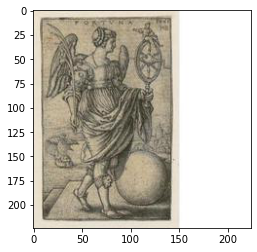

NameError: name 'create_image_query_from_fpath' is not defined

In [50]:
test_an_id(0, retrieval_model, retrieval_exclusion_model)

In [31]:
# save the retrieval model
save_options = tf.saved_model.SaveOptions(namespace_whitelist=["Scann",])
retrieval_model.save("../models/retrieval/2",options=save_options)

# save the retrieval exclusion model
# if using scann, a custom op needs to be whitelisted
save_options = tf.saved_model.SaveOptions(namespace_whitelist=["Scann",])
retrieval_exclusion_model.save("../models/retrieval_exclusion/2",options=save_options)

INFO:tensorflow:Assets written to: ../models/retrieval/2/assets
INFO:tensorflow:Assets written to: ../models/retrieval_exclusion/2/assets
